# MobileNet v1

- Paper: [2017.04.17] MobileNets; Efficient Convolutional Neural Networks for Mobile Vision Applications
- https://arxiv.org/abs/1704.04861

### [Package load]

In [ ]:
import torch 
print('pytorch version: {}'.format(torch.__version__))

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

### [Model: MobileNet v1]

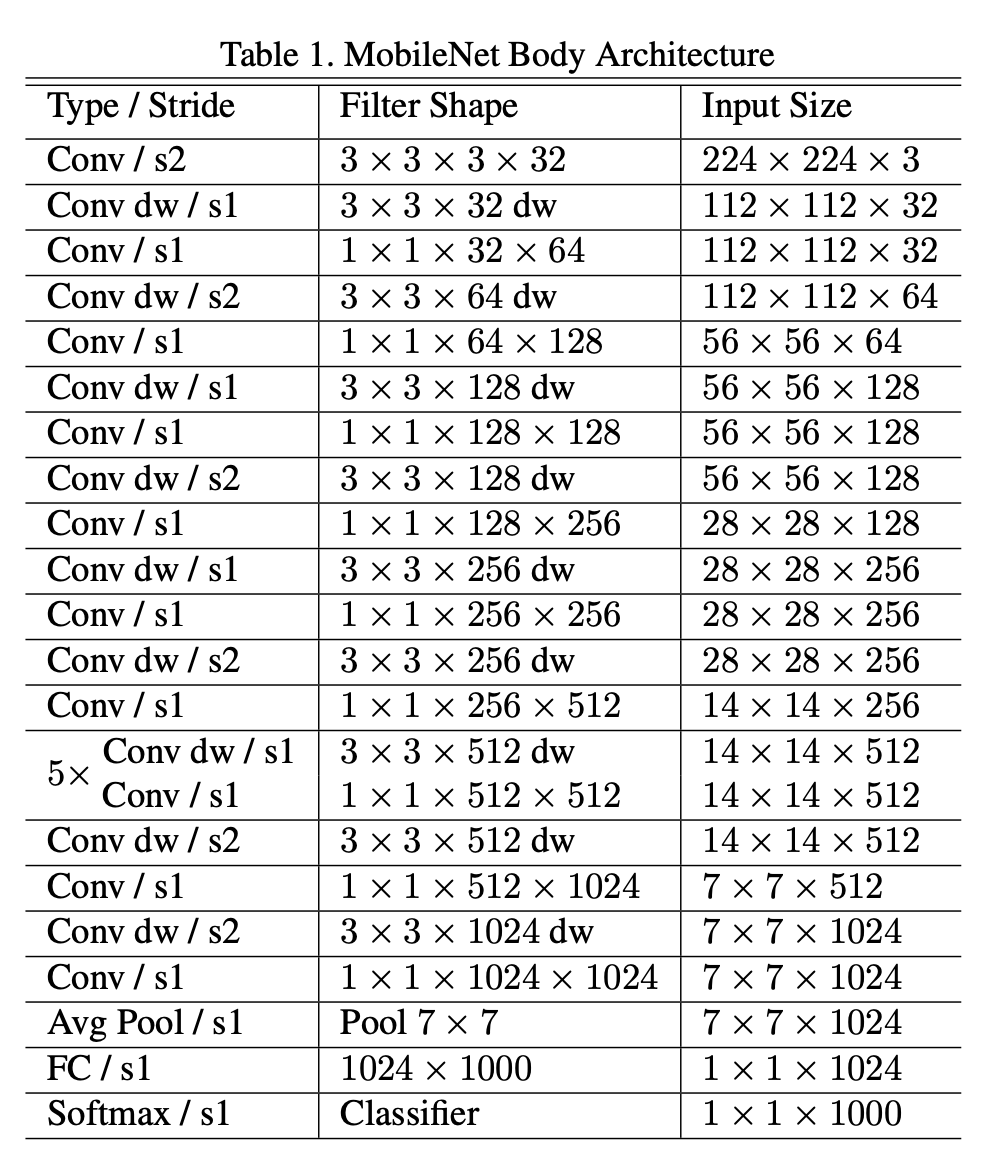

In [ ]:
class DepthPointConv(nn.Module):
    def __init__(self, in_channel, out_channel, depth_stride, point_stride):
        super().__init__()
        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channel, in_channel, 3, stride = depth_stride, groups=in_channel, padding=1, bias=False),  #groups에 in channel을 하면 각각의 input channel이 각각의 output channel에 대응되어 convolution 연산
            nn.BatchNorm2d(in_channel),
            nn.ReLU(inplace = True)
        )
        self.pointwise = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, stride = point_stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class MobileNet(nn.Module):
    def __init__(self, num_classes, alpha=1.0):    # alpha = width multiplier (0, 1] -> Width를 줄여주는 효과 = model을 더 축소시키는 효과
        super().__init__()
        self.stem_conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride = 2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True)
        )
        self.convblock1 = nn.Sequential(
            DepthPointConv(in_channel=int(32*alpha), out_channel=int(64*alpha), depth_stride=1, point_stride=1),
            DepthPointConv(in_channel=int(64*alpha), out_channel=int(128*alpha), depth_stride=2, point_stride=1),
            DepthPointConv(in_channel=int(128*alpha), out_channel=int(128*alpha), depth_stride=1, point_stride=1),
            DepthPointConv(in_channel=int(128*alpha), out_channel=int(256*alpha), depth_stride=2, point_stride=1),
            DepthPointConv(in_channel=int(256*alpha), out_channel=int(256*alpha), depth_stride=1, point_stride=1),
            DepthPointConv(in_channel=int(256*alpha), out_channel=int(512*alpha), depth_stride=2, point_stride=1)
        )
        self.convblock2 = nn.Sequential(
            DepthPointConv(in_channel=int(512*alpha), out_channel=int(512*alpha), depth_stride=1, point_stride=1),
            DepthPointConv(in_channel=int(512*alpha), out_channel=int(512*alpha), depth_stride=1, point_stride=1),
            DepthPointConv(in_channel=int(512*alpha), out_channel=int(512*alpha), depth_stride=1, point_stride=1),
            DepthPointConv(in_channel=int(512*alpha), out_channel=int(512*alpha), depth_stride=1, point_stride=1),
            DepthPointConv(in_channel=int(512*alpha), out_channel=int(512*alpha), depth_stride=1, point_stride=1)
        )
        self.convblock3 = nn.Sequential(
            DepthPointConv(in_channel=int(512*alpha), out_channel=int(1024*alpha), depth_stride=2, point_stride=1),
            DepthPointConv(in_channel=int(1024*alpha), out_channel=int(1024*alpha), depth_stride=2, point_stride=1),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(in_features=1024, out_features=num_classes, bias=True)
    
    def forward(self, x):
        x = self.stem_conv(x)
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)       # x.size(0) = batch size
        x = self.fc(x)
        return x

In [ ]:
mobilenet_v1 = MobileNet(num_classes=4).to(device)

In [ ]:
mobilenet_v1

MobileNet(
  (stem_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convblock1): Sequential(
    (0): DepthPointConv(
      (depthwise): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (pointwise): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): DepthPointConv(
      (depthwise): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
        (1): BatchNorm2d(64, 

In [ ]:
temp = torch.Tensor(np.random.randint(1, 255, size=(1, 3, 224, 224)))
mobilenet_v1(temp)

tensor([[-0.0238, -0.0413,  0.2786, -0.1109]], grad_fn=<AddmmBackward0>)

In [ ]:
from torchsummary import summary
summary(mobilenet_v1, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              ReLU-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]          18,432
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
   DepthPointConv-10         [-1, 64, 112, 112]               0
           Conv2d-11           [-1, 64, 56, 56]             576
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
           Conv2d-14          [-1, 128,

In [ ]:
from torchinfo import summary
summary(mobilenet_v1, input_size=(1, 3, 224, 224), col_width=20, depth=100, row_settings=["depth", "var_names"], col_names=["input_size", "kernel_size", "output_size", "params_percent"])

Layer (type (var_name):depth-idx)             Input Shape          Kernel Shape         Output Shape         Param %
MobileNet (MobileNet)                         [1, 3, 224, 224]     --                   [1, 4]                    --
├─Sequential (stem_conv): 1-1                 [1, 3, 224, 224]     --                   [1, 32, 112, 112]         --
│    └─Conv2d (0): 2-1                        [1, 3, 224, 224]     [3, 3]               [1, 32, 112, 112]      0.00%
│    └─BatchNorm2d (1): 2-2                   [1, 32, 112, 112]    --                   [1, 32, 112, 112]      0.00%
│    └─ReLU (2): 2-3                          [1, 32, 112, 112]    --                   [1, 32, 112, 112]         --
├─Sequential (convblock1): 1-2                [1, 32, 112, 112]    --                   [1, 512, 14, 14]          --
│    └─DepthPointConv (0): 2-4                [1, 32, 112, 112]    --                   [1, 64, 112, 112]         --
│    │    └─Sequential (depthwise): 3-1       [1, 32, 112, 112] 